In [1]:
import ete3
import os
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import subprocess
from scipy.stats import spearmanr, linregress
import itertools
from Bio import SeqIO, SearchIO, AlignIO, Align, Alphabet
import re
import multiprocessing
from copy import deepcopy
from scipy.stats import ttest_ind, wilcoxon

class cd:
    """
    Context manager for changing the current working directory
    """
    def __init__(self, newPath):
        self.newPath = os.path.expanduser(newPath)

    def __enter__(self):
        self.savedPath = os.getcwd()
        os.chdir(self.newPath)

    def __exit__(self, etype, value, traceback):
        os.chdir(self.savedPath)

os.chdir('/work/site_rate/hug_et_al')
ncbi        = ete3.NCBITaxa()
num_threads = 10

<h3 align="center">Precomputed data</h3>

In [2]:
tree = ete3.Tree('ribosomal_concat.fasta.treefile', format=1)

In [3]:
bacteria     = []
archaea      = []
eukarya      = []
for leaf in tree.get_leaf_names():
    if leaf.startswith('Bacteria'):
        bacteria.append(leaf)
    elif leaf.startswith('Archaea'):
        archaea.append(leaf)
    elif leaf.startswith('Eukaryota'):
        eukarya.append(leaf)

In [4]:
tree.set_outgroup(eukarya[0])
bacteria_ancestor = tree.get_common_ancestor(bacteria)
tree.set_outgroup(bacteria_ancestor)

In [6]:
os.chdir('/work/site_rate/hug_et_al/categories/')
tree.write(outfile='species.tre', dist_formatter='%.20f', format=5)

In [7]:
number_of_rate_categories  = 12

category_support_df = pd.DataFrame(columns='category topology_id support branch_length'.split())
for category in range(1,number_of_rate_categories+1):
    print category
    
    tmp_tree = ete3.Tree('%i.treefile' %category)

    tmp_tree.set_outgroup(eukarya[0])
    outgroup = tmp_tree.get_common_ancestor(bacteria)
    tmp_tree.set_outgroup(outgroup)

    tmp_supports       = []
    tmp_topology_ids   = []
    tmp_branch_lengths = []
    for node in tmp_tree.traverse():
        if not node.is_leaf() and not node.is_root():
            tmp_supports.append(node.support)
            tmp_topology_ids.append(node.get_topology_id())
            tmp_branch_lengths.append(node.dist)

    tmp_df = pd.DataFrame(
                zip([category]*len(tmp_supports),
                    tmp_topology_ids,
                    tmp_supports,
                    tmp_branch_lengths),
                columns='category topology_id support branch_length'.split())
    category_support_df = category_support_df.append(tmp_df)

for node in tree.traverse():
    if not node.is_leaf() and not node.is_root():
        tmp_topology_id = node.get_topology_id()
        category_support_df.loc[category_support_df.topology_id == tmp_topology_id, 'branch_length'] = node.dist

#category_support_df.to_csv('category_supports.tab', sep='\t')

1
2
3
4
5
6
7
8
9
10
11
12


In [28]:
#category_support_df = pd.read_table('categories/category_supports.tab', index_col=0)
category_support_df.head()

,category,topology_id,support,branch_length,distance2root
0,1,5ab0ed49cf2898ce1671bbdb7620f7c5,100.0,0.541224,0.0
1,1,5c80f227dec770ed3b626bfbb8b66a82,100.0,0.541224,0.0
2,1,608e84e26f6046c7ab5b7fa72358303a,0.0,0.068087,1.0
3,1,7bdf497c0041740487353592f2a557a8,0.0,0.040782,1.0
4,1,39049918f24f9029151fd33640795878,100.0,0.147036,1.0


In [21]:
sorter_index = {}
for node in tree.traverse():
    if node.is_root() or node.is_leaf():
        continue
    tmp_topology_id = node.get_topology_id()
    node.add_feature('topology_id', tmp_topology_id)
    sorter_index[tmp_topology_id] = tree.get_distance(node, topology_only=True)

category_support_df['distance2root'] = category_support_df['topology_id'].map(sorter_index)

In [117]:
correlation

[-0.13285177541144405,
 -0.1307589348454341,
 -0.16516843786350482,
 -0.13937414212649474,
 -0.1270160207125371,
 -0.12988545886557123,
 -0.09266559585031536,
 -0.05676691883261731,
 -0.06183565890419117,
 -0.012305462043180644,
 0.0022244123793141216,
 0.02947668096055567]

In [108]:
correlation = []
pvalue      = []
slope       = []
distance2root = {category:[] for category in range(1, 13)}
support       = {category:[] for category in range(1, 13)}
for category in range(1,13):
    tmp          = category_support_df[category_support_df.category == category].copy()
    
    distance2root[category].extend(tmp.distance2root.tolist())
    support[category].extend(tmp.support.tolist())
    
    tmp_spearman = spearmanr(tmp.support.tolist(), tmp.distance2root.tolist())
    correlation.append(tmp_spearman.correlation)
    pvalue.append(tmp_spearman.pvalue)
    regression   = linregress(tmp.support.tolist(), tmp.distance2root.tolist())
    slope.append(regression.slope)
    

ValueError: Mutually exclusive regression options.

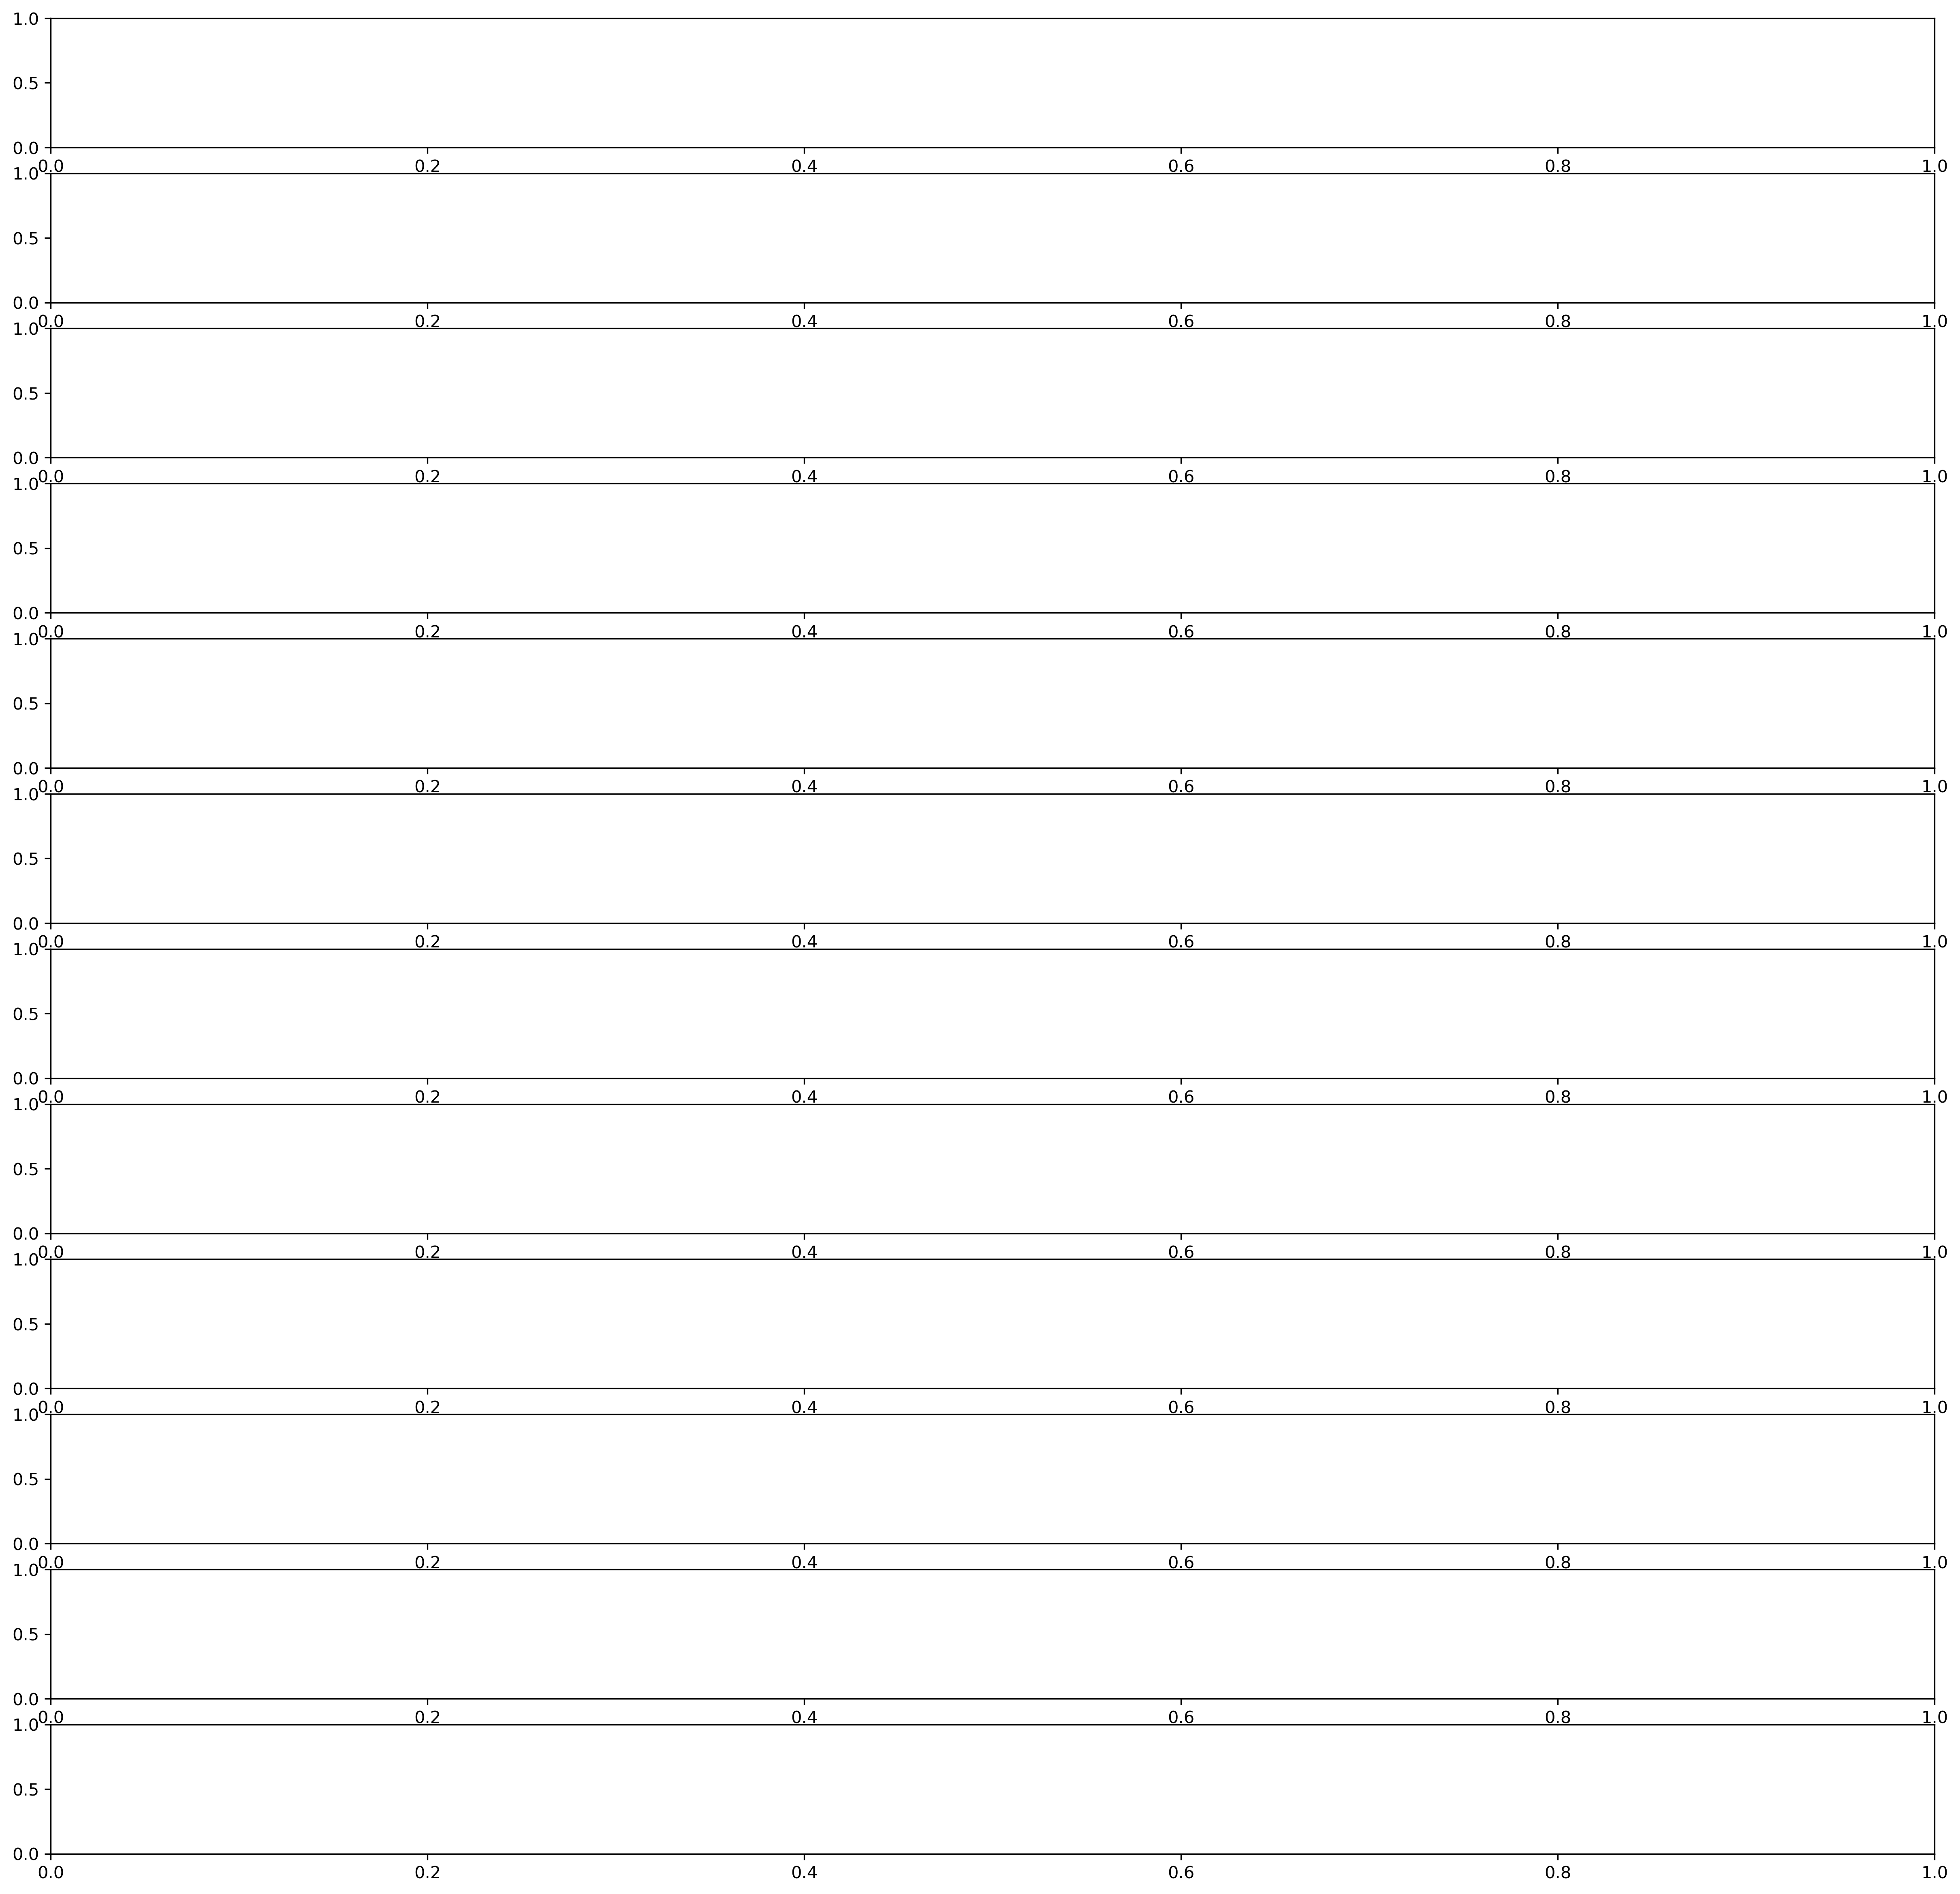

In [116]:
fig, axs = plt.subplots(nrows=12, dpi=300, figsize=(20, 20))
for category, ax in enumerate(axs, 1):
    tmp = category_support_df[category_support_df.category == category].copy()
    sns.regplot(x='distance2root', y='support', data=tmp, logistic=True, robust=True, n_boot=100, ax=ax)

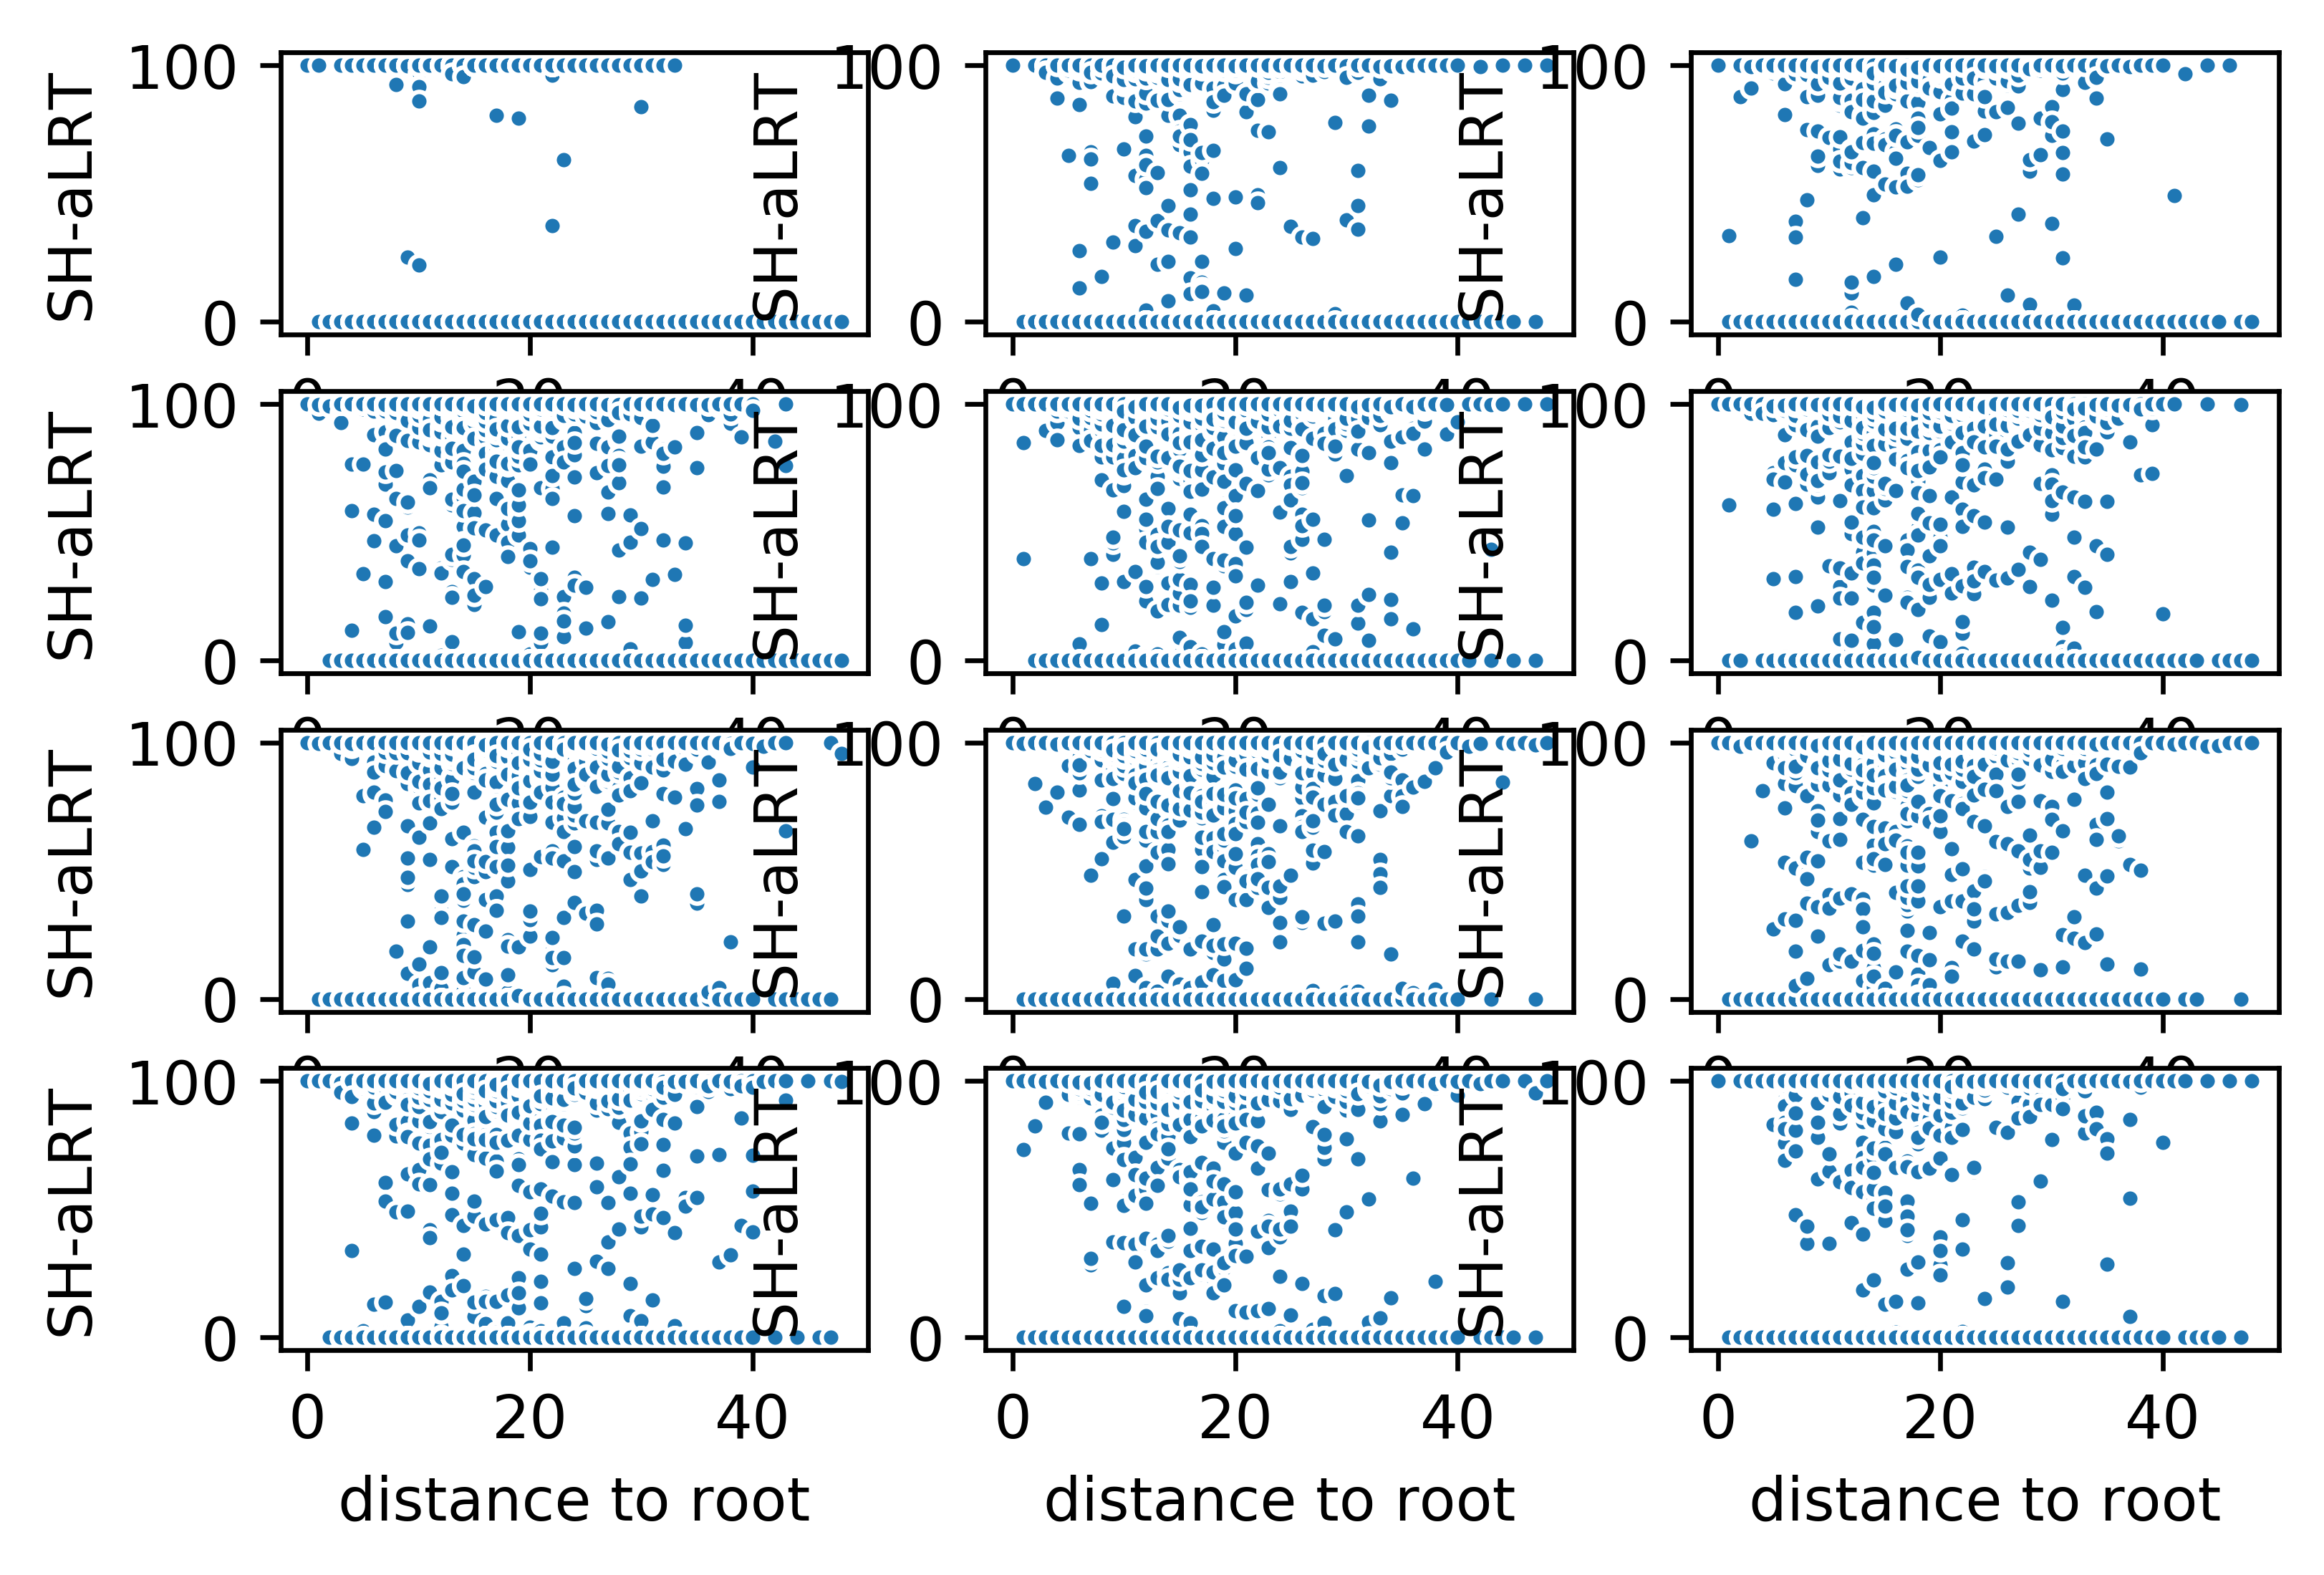

In [87]:
fig, axs = plt.subplots(nrows=4, ncols=3, dpi=600)
for category, ax in zip(range(1, 13), axs.flatten()):
    x = pd.Series(distance2root[category], name='distance to root')
    y = pd.Series(support[category], name='SH-aLRT')
    sns.scatterplot(x=x, y=y, ax=ax, s=10)

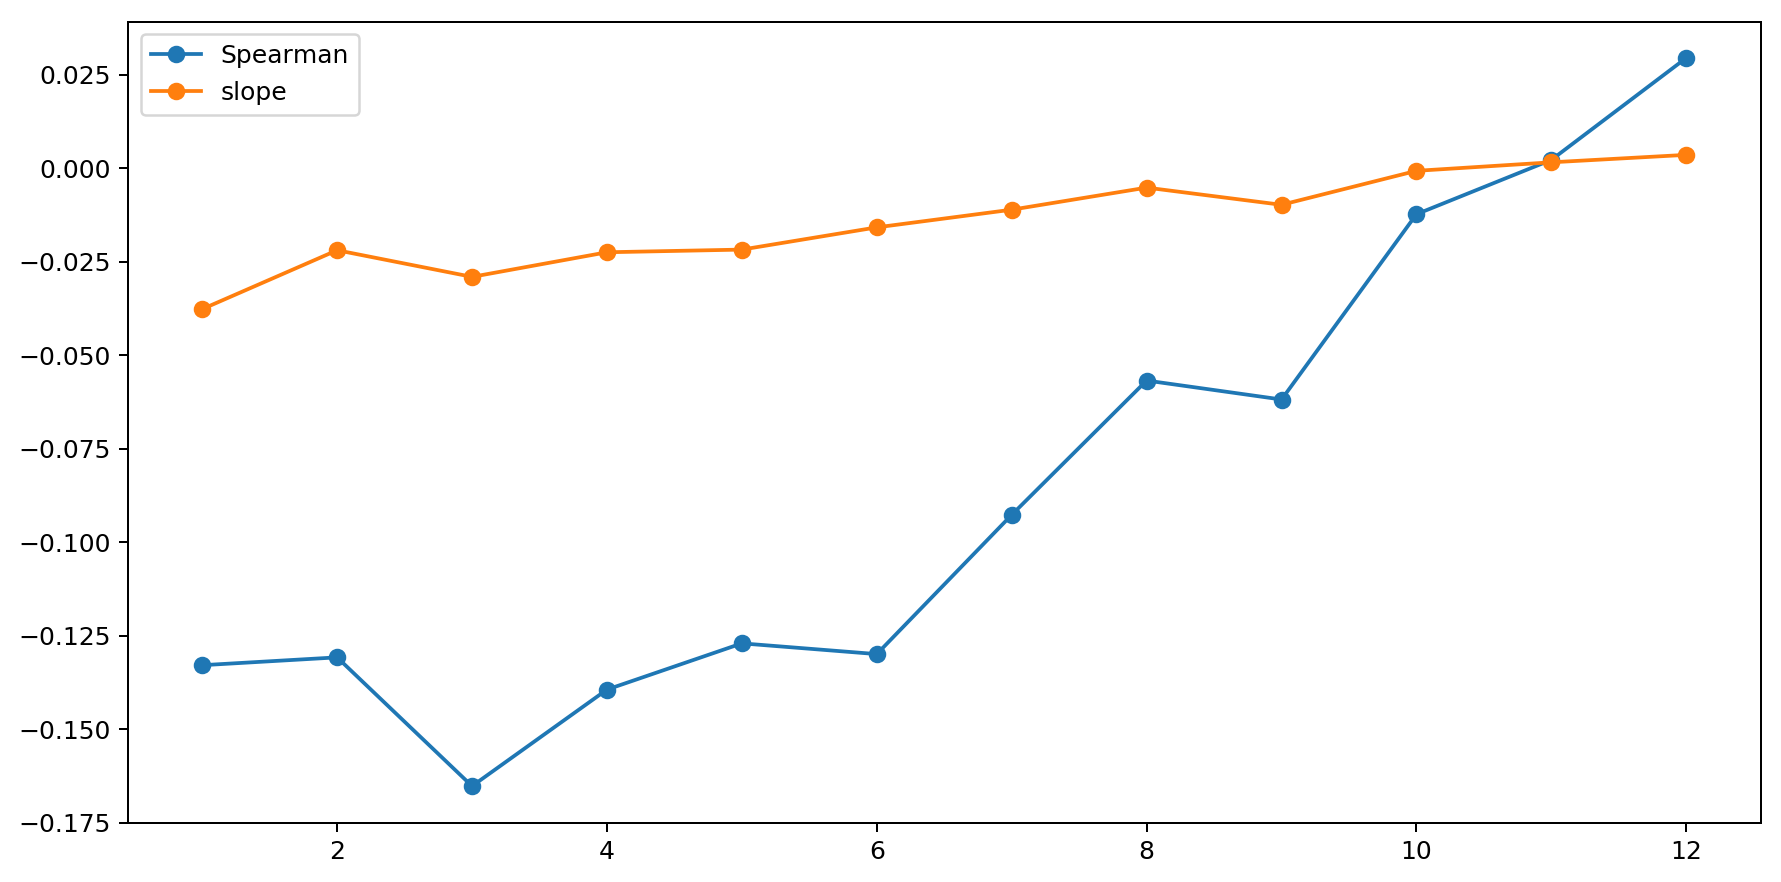

In [54]:
fig, axs = plt.subplots(dpi=180, figsize=(10,5))
axs.plot(range(1, 13), correlation, marker='o', label='Spearman')
axs.plot(range(1, 13), slope, marker='o', label='slope')
axs.legend()
fig.tight_layout()


In [29]:
regression_results = {}
for category in range(1, 13):
    spearman = []
    pearson  = []
    slopes   = []
    for leaf in tree.get_leaves():
        if len(leaf.get_ancestors()) <= 10:
            continue
        topology_ids = [node.topology_id for node in leaf.get_ancestors() if not node.is_root()]
        tmp = category_support_df[(category_support_df.topology_id.isin(topology_ids))&
                                  (category_support_df.category == category)].copy()
        
        regression = linregress(tmp.support.tolist(), tmp.distance2root.tolist())
        slopes.append(regression.slope)
        pearson.append(regression.rvalue)
        spearman.append(spearmanr(tmp.support.tolist(), tmp.distance2root.tolist()).correlation)
    
    spearman = np.asarray(spearman)
    pearson  = np.asarray(pearson)
    slopes   = np.asarray(slopes)
    
    regression_results[category] = {'spearman':spearman, 'pearson':pearson, 'slopes':slopes}
    
#    sns.kdeplot(slopes[pd.notnull(slopes)], ax=axs[category-1], shade=True)
#    break

(-0.1, 0.1)

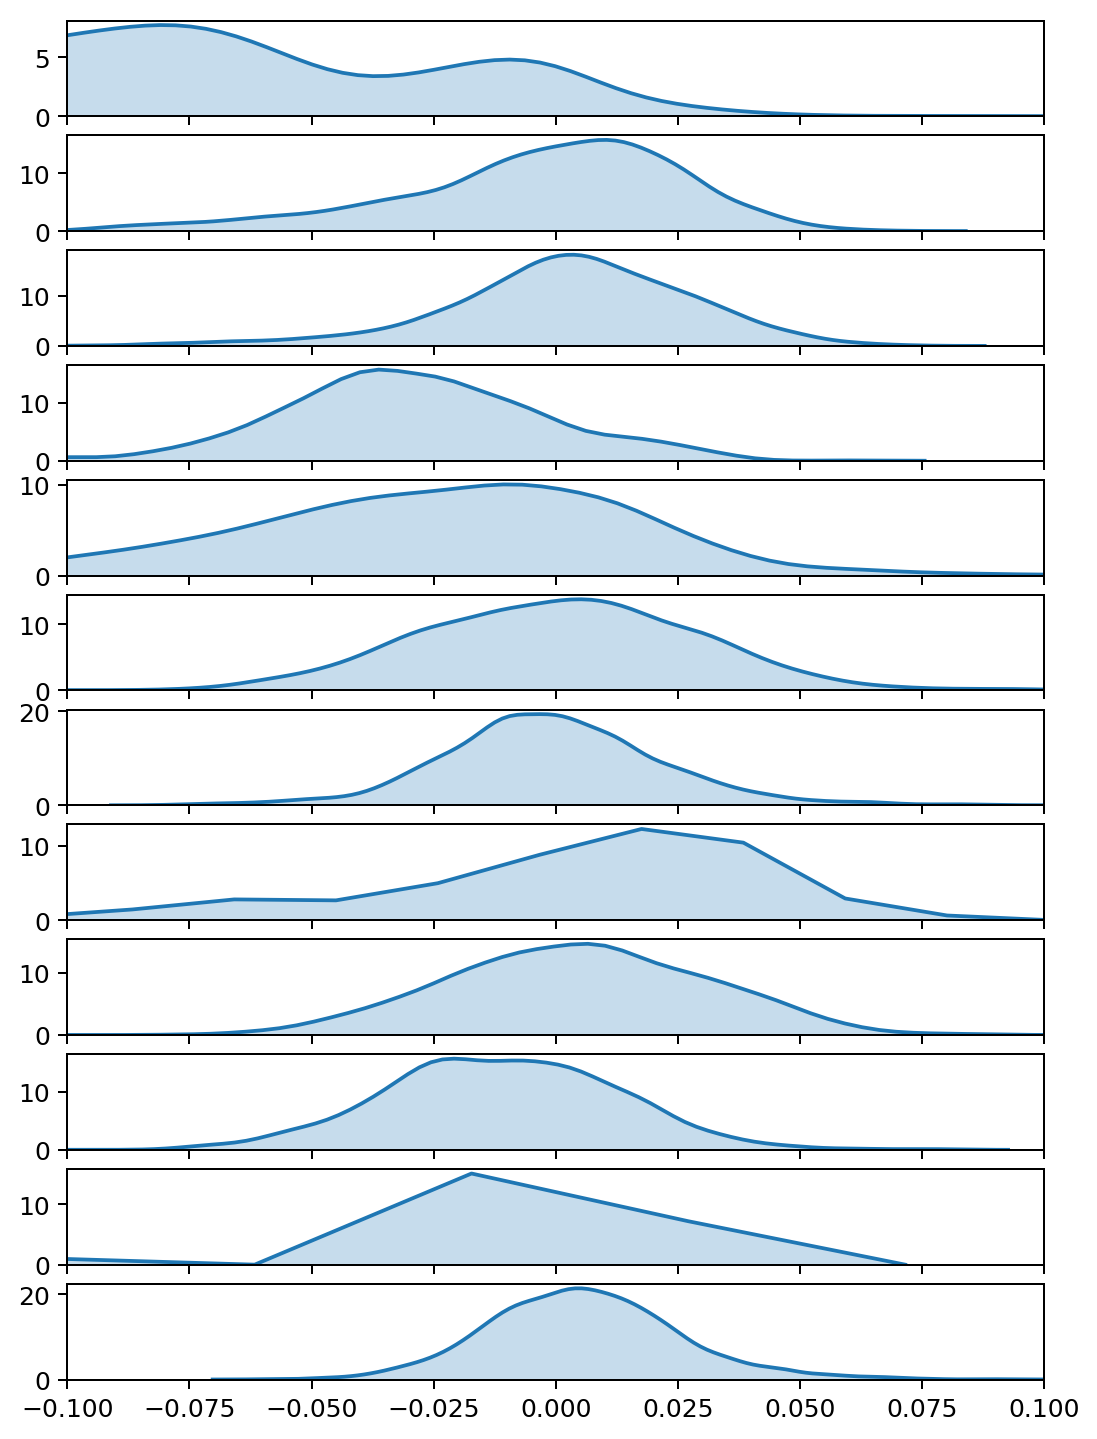

In [35]:
metric = 'slopes'
fig, axs = plt.subplots(nrows=12, sharex=True, figsize=(7, 10), dpi=180)
for category, regression_values in regression_results.items():
    sns.kdeplot(regression_values[metric][(pd.notnull(regression_values[metric]))],
                ax=axs[category-1], shade=True)
axs[11].set_xlim(-0.1,0.1)

In [ ]:
regression_values[metric][(pd.notnull(regression_values[metric]))&
                                          (regression_values[metric] != 0)]

In [ ]:
branch_lengths = category_support_df.loc[
    category_support_df.category == 1,
    'branch_length'.split()].values.squeeze()

branch_length_bins = [np.percentile(branch_lengths, decile) for decile in range(10, 91, 10)]
binning            = np.digitize(category_support_df['branch_length'].values.squeeze(), branch_length_bins)
bin_names          = {}

for bin in set(binning):
    min_binned_branch_len = category_support_df.loc[binning==bin, 'branch_length'].values.squeeze().min()
    max_binned_branch_len = category_support_df.loc[binning==bin, 'branch_length'].values.squeeze().max()
    bin_names[bin]        = '%.2e - %.2e' % (min_binned_branch_len, max_binned_branch_len)

category_support_df['branch_length_bin'] = [bin_names[bin] for bin in binning]

In [ ]:
import scipy.stats as stats
fit_alpha, fit_loc, fit_beta=stats.gamma.fit(branch_lengths)
print(fit_alpha, fit_loc, fit_beta)

print stats.gamma.pdf(0.1, fit_alpha, loc=fit_loc, scale=fit_beta)
print branch_lengths.max()

In [ ]:
len([branch for branch in tree.get_edges() if len(branch[0]) > 1 and len(branch[1]) > 1])

In [ ]:
tree.get_edges?

In [ ]:
fig, ax = plt.subplots(dpi=180)
sns.kdeplot(branch_lengths, shade=True, ax=ax)
sns.kdeplot(stats.gamma.rvs(fit_alpha, loc=fit_loc, scale=fit_beta, size=10000), shade=True, ax=ax)
fig.set_size_inches(7,4)

In [ ]:
fig, ax = plt.subplots(dpi=120)
sns.boxplot(x='branch_length_bin', y='support', hue='category', order=bin_names.values(), data=category_support_df, ax=ax)
fig.set_size_inches(25,6)
ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.015), title='Site-rate category',frameon=False)
fig.tight_layout()
#fig.savefig('support_binned_by_branch_length-decile_binned.pdf', dpi=300)
#plt.close()

In [ ]:
print category_support_df.branch_length_bin.unique()
category_support_df.loc[(category_support_df.branch_length_bin== '7.91e-02 - 1.07e-01') &
                    (category_support_df.category== 12), 'support'].median()

In [ ]:
fig, ax = plt.subplots(dpi=180)
sns.kdeplot(category_support_df.loc[category_support_df.category==2, 'support'].tolist(), label='slow-evolving', shade=True, ax=ax, bw=1)
sns.kdeplot(category_support_df.loc[category_support_df.category==11, 'support'].tolist(), label='fast-evolving', shade=True, ax=ax, bw=1)
fig.set_size_inches(7,4)
wilcoxon(category_support_df.loc[category_support_df.category==2, 'support'].tolist(),
          category_support_df.loc[category_support_df.category==11, 'support'].tolist())

In [ ]:
category_support_df.head()

In [ ]:
quartile_1 = np.percentile(br_len, 25)
quartile_3 = np.percentile(br_len, 75)
short_br_support = []
long_br_support  = []
for length, support in zip(br_len, br_sup):
    if length <= quartile_1:
        short_br_support.append(support)
    elif length >= quartile_3:
        long_br_support.append(support)

fig, ax = plt.subplots(dpi=180)
sns.kdeplot(pd.Series(data=short_br_support, name='Short branches'), shade=True, ax=ax, bw=1)
sns.kdeplot(pd.Series(data=long_br_support, name='Long branches'), shade=True, ax=ax, bw=1)
fig.set_size_inches(7,4)

In [ ]:
ttest_ind(short_br_support, long_br_support)

In [ ]:
np.mean(long_br_support)